In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import warnings  
warnings.filterwarnings('ignore')

In [2]:
input_dir = "C:/Users/Kaushik/Desktop/anacondaDocs/analytics-vidhya-apperal problem/"
print("directory of dataset:",input_dir)

directory of dataset: C:/Users/Kaushik/Desktop/anacondaDocs/analytics-vidhya-apperal problem/


In [3]:
if torch.cuda.is_available:
    device="cuda"
else:
    device="cpu"
print("device training on:",device)

device training on: cuda


In [4]:
train_df = pd.read_csv(input_dir+"train.csv")
train_df.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [5]:
train_df.isnull().sum()

id       0
label    0
dtype: int64

In [6]:
test_df = pd.read_csv(input_dir+"test.csv")
test_df.head()

,id
0,60001
1,60002
2,60003
3,60004
4,60005


In [7]:
class apperal_dataset(Dataset):
    def __init__(self, df, folder, transforms, labels):
        self.df = df
        self.folder = folder
        self.transforms = transforms
        self.labels = labels
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        img_id = str(self.df.loc[idx,"id"])
        img_src = input_dir +self.folder +"/" +img_id + ".png"
        image = cv2.imread(img_src,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.from_numpy(image)
        image = image.to(dtype=torch.float)
        if(self.labels):
            labels = torch.tensor(self.df.loc[idx,"label"])
            return image, labels
        else:
            return image

In [8]:
transform = transforms.Compose([transforms.ToTensor()])

In [9]:
trainset = apperal_dataset(df=train_df, folder="train", transforms = transform,labels=True)
testset= apperal_dataset(df=test_df, folder="test", transforms = transform,labels=False)

In [10]:
# hyper parameters
BATCH_SIZE = 64
EPOCHS = 7

In [11]:
num_workers = 0
validation_size = 0.2

number_of_training_data = len(trainset)
indices = list(range(number_of_training_data))
np.random.shuffle(indices)
split = int(np.floor(validation_size * number_of_training_data))
train_idx, validation_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(validation_idx)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers = num_workers)
validation_loader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers = num_workers)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

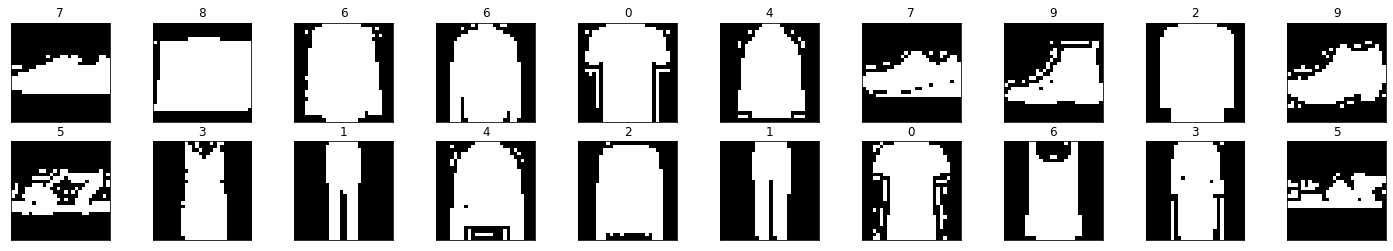

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [13]:
class classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2352,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
    
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [14]:
model = classifier()

if torch.cuda.is_available:
    device = "cuda"
else:
    device = cpu
print("using device:",device)
print(model)

using device: cuda
classifier(
  (fc1): Linear(in_features=2352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [15]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [16]:
# number of epochs to train the model
n_epochs = 10

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in validation_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.934949 	Validation Loss: 0.105466
Validation loss decreased (inf --> 0.105466).  Saving model ...
Epoch: 2 	Training Loss: 0.377328 	Validation Loss: 0.085758
Validation loss decreased (0.105466 --> 0.085758).  Saving model ...
Epoch: 3 	Training Loss: 0.339656 	Validation Loss: 0.081989
Validation loss decreased (0.085758 --> 0.081989).  Saving model ...
Epoch: 4 	Training Loss: 0.322728 	Validation Loss: 0.097350
Epoch: 5 	Training Loss: 0.327373 	Validation Loss: 0.083581
Epoch: 6 	Training Loss: 0.322819 	Validation Loss: 0.083441
Epoch: 7 	Training Loss: 0.328432 	Validation Loss: 0.087111
Epoch: 8 	Training Loss: 0.321784 	Validation Loss: 0.089520
Epoch: 9 	Training Loss: 0.323672 	Validation Loss: 0.081524
Validation loss decreased (0.081989 --> 0.081524).  Saving model ...
Epoch: 10 	Training Loss: 0.322314 	Validation Loss: 0.082907


In [17]:
submission_file = pd.read_csv("sample_submission_I5njJSF (1).csv")
submission_file.head()
print(len(submission_file))

10000


In [18]:
model.load_state_dict(torch.load('model.pt'))

model.eval()
test_preds = None
for data in test_loader:
    outputs = model(data)
    if test_preds is None:
        test_preds = outputs.data.cpu()
    else:
        test_preds = torch.cat((test_preds, outputs.data.cpu()), dim=0)
        
_, preds = torch.max(test_preds, 1)

In [19]:
print(preds)

tensor([9, 2, 1,  ..., 8, 1, 5])


In [20]:
submission_file["label"] = preds

In [21]:
submission_file.to_csv('submission_file.csv', index=False)